⚠️ Avoid using cut/paste for binary files in JupyterLab!
Use download/upload or terminal-based `mv` commands instead.

## 🛠️ File & Folder Management in Terminal

### 🚚 Move a file
mv source_file.tif target_folder/

### Move a whole directory:
mv old_folder/ new_folder/

### 📑 Copy a file (safely, leave original intact)
cp source_file.tif target_folder/

### 📁 Create a new directory
mkdir my_new_folder

### ❌ Delete a file (⚠️ irreversible!)
rm unwanted_file.tif

###🗑️ Delete a folder + contents (be careful!)
rm -r folder_name/

### 🔍 List files (to double-check first!)
ls -lh

### 🧪 Check file size
du -h filename.tif

### Pro tip
### 🪄 Want to make it runnable in a notebook cell?

Just prefix any command with `!` like:

```python
!mv bad_folder/*.tif fixed_folder/
!ls -lh fixed_folder/


In [4]:
# --- Bootstrap: install missing packages & set environment ---
import sys
import subprocess
import os

required = [
    "xarray", "rioxarray", "rasterio", "geopandas", "matplotlib",
    "scipy", "openpyxl", "shapely", "pandas", "netCDF4" 
]

installed_something = False

def install_missing(packages):
    global installed_something
    for pkg in packages:
        try:
            __import__(pkg)
        except ImportError:
            print(f"📦 Installing {pkg}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
            installed_something = True

# 🛠️ Install what's missing
install_missing(required)

# 📁 Set working dir to persistent folder
os.chdir("/home/jovyan/mystorage")
print("✅ Working from:", os.getcwd())

# 🔁 Restart suggestion only if installs happened
if installed_something:
    print("⚠️ One or more packages were installed.")
    print("🔁 Please restart the kernel now, then re-run this notebook from the top.")
else:
    print("✅ All required packages are already installed.")

📦 Installing netCDF4...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.0 MB/s eta 0:00:00
✅ Working from: /home/jovyan/mystorage
⚠️ One or more packages were installed.
🔁 Please restart the kernel now, then re-run this notebook from the top.


In [12]:
# This notebooks takes care of the preparation of the input files (aligning and reprojection). 
# A next version should load data from CDSE or Wekeo API automatically, based on aoi and period of interest
# 18-04-2024: not tested yet
# --- Cell 1: Imports & folder setup for input preparation ---
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box, mapping
import shapely.ops
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 📁 Directories
base_dir = "/home/jovyan/mystorage/NPP_project"
raw_dir = os.path.join(base_dir, "NPP_inputs/CLMS_products")        # Where original downloads live
input_dir = os.path.join(base_dir, "NPP_inputs")         # Where prepped rasters go
vector_dir = os.path.join(base_dir, "Provinces_NL")      # Vector boundary source

os.makedirs(input_dir, exist_ok=True)
print("📦 Input preparation directories ready.")


📦 Input preparation directories ready.


In [6]:
import zipfile
import os

# 🔍 Set your zip file path (adjust name if needed)
zip_path = "/home/jovyan/mystorage/NPP_project/NPP_inputs/CLMS_products/VI_20220510T104621_S2A_T31UFT-010m_V101_FAPAR_FIXED_Qgis.zip"
extract_to = "/home/jovyan/mystorage/NPP_project/NPP_inputs/CLMS_products/"

# 🔓 Extract safely
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ ZIP extracted to:", extract_to)


✅ ZIP extracted to: /home/jovyan/mystorage/NPP_project/NPP_inputs/CLMS_products/


In [7]:
import rasterio
import xarray as xr
import os

def check_file_metadata(file_paths):
    for path in file_paths:
        print(f"🔍 Checking: {os.path.basename(path)}")
        try:
            if path.endswith(".tif"):
                with rasterio.open(path) as src:
                    print(" ✅ GeoTIFF opened successfully.")
                    print(f"    - CRS:         {src.crs}")
                    print(f"    - Size:        {src.width} x {src.height}")
                    print(f"    - Dtype:       {src.dtypes}")
                    print(f"    - Tiled:       {src.is_tiled}")
                    print(f"    - Compression: {src.compression}")
            elif path.endswith(".nc"):
                ds = xr.open_dataset(path)
                print(" ✅ NetCDF opened successfully.")
                print(f"    - Dimensions:  {list(ds.dims.items())}")
                print(f"    - Variables:   {list(ds.data_vars)}")
                print(f"    - Coordinates: {list(ds.coords)}")
                ds.close()
            else:
                print(" ⚠️ Unknown file type — skipping.")
        except Exception as e:
            print(f" ❌ Failed to open: {e}")
        print("-" * 60)

# 🧪 Usage: combine TIF and NC files
files_to_check = [
    "/home/jovyan/mystorage/NPP_project/NPP_inputs/CLMS_products/VI_20220510T104621_S2A_T31UGT-010m_V101_LAI_FIXED_Qgis.tif",
    "/home/jovyan/mystorage/NPP_project/NPP_inputs/CLMS_products/VI_20220510T104621_S2A_T31UFT-010m_V101_LAI_FIXED_Qgis.tif",
    "/home/jovyan/mystorage/NPP_project/NPP_inputs/CLMS_products/VI_20220510T104621_S2A_T31UGT-010m_V101_FAPAR_FIXED_Qgis.tif",
    "/home/jovyan/mystorage/NPP_project/NPP_inputs/CLMS_products/VI_20220510T104621_S2A_T31UFT-010m_V101_FAPAR_FIXED_Qgis.tif",
    "/home/jovyan/mystorage/NPP_project/NPP_inputs/CLMS_products/single_level_2m_daily_mean_temp_2022_NL_ERA5.nc",
    "/home/jovyan/mystorage/NPP_project/NPP_inputs/CLMS_products/single_level_daily_accumulated_DSSF_2022_NL_ERA5.nc"
]

check_file_metadata(files_to_check)


🔍 Checking: VI_20220510T104621_S2A_T31UGT-010m_V101_LAI_FIXED_Qgis.tif
 ✅ GeoTIFF opened successfully.
    - CRS:         EPSG:32631
    - Size:        10980 x 10980
    - Dtype:       ('float32',)
    - Tiled:       False
    - Compression: None
------------------------------------------------------------
🔍 Checking: VI_20220510T104621_S2A_T31UFT-010m_V101_LAI_FIXED_Qgis.tif
 ✅ GeoTIFF opened successfully.
    - CRS:         EPSG:32631
    - Size:        10980 x 10980
    - Dtype:       ('float32',)
    - Tiled:       False
    - Compression: None
------------------------------------------------------------
🔍 Checking: VI_20220510T104621_S2A_T31UGT-010m_V101_FAPAR_FIXED_Qgis.tif
 ✅ GeoTIFF opened successfully.
    - CRS:         EPSG:32631
    - Size:        10980 x 10980
    - Dtype:       ('float32',)
    - Tiled:       False
    - Compression: None
------------------------------------------------------------
🔍 Checking: VI_20220510T104621_S2A_T31UFT-010m_V101_FAPAR_FIXED_Qgis.tif
 

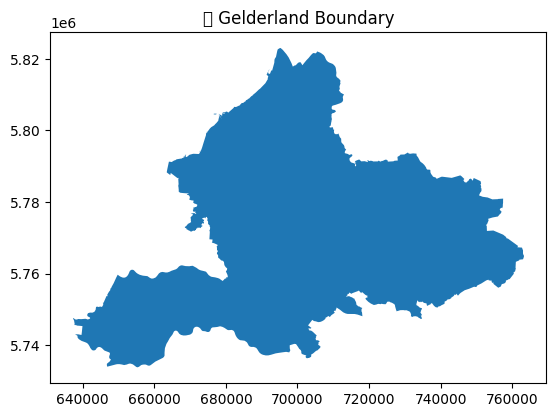

In [10]:
# --- Cell 2: Load and reproject Gelderland boundary ---

# 📍 Load Dutch provinces shapefile
provinces = gpd.read_file(os.path.join(vector_dir, "pv_2022.shp"))

# 🎯 Select Gelderland by name
gelderland = provinces[provinces["PV_NAAM"].str.contains("Gelderland", case=False)]

# 🧭 Reproject to UTM Zone 31N (EPSG:32631) — matches Sentinel-2
gelderland = gelderland.to_crs("EPSG:32631")

# 💠 Geometry as mask
gelderland_geom = [mapping(g) for g in gelderland.geometry]

# Preview
gelderland.plot()
plt.title("📍 Gelderland Boundary")
plt.show()


In [15]:
# --- Cell 3: Memory-safe mosaic & clip for LAI and FAPAR tiles ---

import rioxarray as rxr
import xarray as xr
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
import os

# 🗂️ Define your file sources (UGT + UFT)
tile_files = {
    "LAI": [
        os.path.join(raw_dir, "VI_20220510T104621_S2A_T31UGT-010m_V101_LAI_FIXED_Qgis.tif"),
        os.path.join(raw_dir, "VI_20220510T104621_S2A_T31UFT-010m_V101_LAI_FIXED_Qgis.tif")
    ],
    "FAPAR": [
        os.path.join(raw_dir, "VI_20220510T104621_S2A_T31UGT-010m_V101_FAPAR_FIXED_Qgis.tif"),
        os.path.join(raw_dir, "VI_20220510T104621_S2A_T31UFT-010m_V101_FAPAR_FIXED_Qgis.tif")
    ]
}

# 🌍 Get geometry (assuming you've already loaded the Gelderland boundary as GeoDataFrame)
gelderland_geom = gelderland.geometry.values

# 🧠 Helper function to clip, align and normalize
def load_and_clip(path, geometry, crs_target="EPSG:32631"):
    with rasterio.open(path) as src:
        # Reproject geometry to raster CRS
        if src.crs.to_string() != crs_target:
            gdf_tmp = gpd.GeoDataFrame(geometry=geometry, crs=crs_target)
            gdf_tmp = gdf_tmp.to_crs(src.crs)
            geometry = [mapping(g) for g in gdf_tmp.geometry]
        else:
            geometry = [mapping(g) for g in geometry]

        # Clip to region
        clipped, transform = mask(src, geometry, crop=True)
        # Reload with rioxarray and normalize to [0,1]
        arr = rxr.open_rasterio(path, masked=True).squeeze() / 10000
        arr = arr.rio.write_crs(src.crs).rio.clip(geometry, src.crs)
        arr = arr.rio.reproject(crs_target)
        return arr

# 🌱 Combine LAI tiles
lai_layers = [load_and_clip(p, gelderland_geom).sortby("x").sortby("y") for p in tile_files["LAI"]]
lai_combined = lai_layers[0].combine_first(lai_layers[1])
lai_combined.rio.to_raster(os.path.join(input_dir, "LAI_Gelderland.tif"))

# 🍃 Combine FAPAR tiles
fapar_layers = [load_and_clip(p, gelderland_geom).sortby("x").sortby("y") for p in tile_files["FAPAR"]]
fapar_combined = fapar_layers[0].combine_first(fapar_layers[1])
fapar_combined.rio.to_raster(os.path.join(input_dir, "FAPAR_Gelderland.tif"))

print("✅ LAI and FAPAR tiles clipped, combined, and saved.")


✅ LAI and FAPAR tiles clipped, combined, and saved.


In [17]:
ds = xr.open_dataset(temp_nc_path)
print(ds.dims)
print(ds.coords)
print(ds.data_vars)

FrozenMappingWarningOnValuesAccess({'longitude': 19, 'latitude': 15, 'time': 365})
Coordinates:
  * longitude  (longitude) float32 76B 3.0 3.25 3.5 3.75 ... 6.75 7.0 7.25 7.5
  * latitude   (latitude) float32 60B 54.0 53.75 53.5 53.25 ... 51.0 50.75 50.5
  * time       (time) datetime64[ns] 3kB 2022-01-01 2022-01-02 ... 2022-12-31
Data variables:
    TEMP     (time, latitude, longitude) float64 832kB ...


In [21]:
# --- Cell 4: Extract May & clip ERA5 TEMP + DSSF NetCDFs (Final Fixed Version) ---

import xarray as xr
import geopandas as gpd
from shapely.geometry import box
import os

# 📂 Filepaths
temp_nc_path = os.path.join(raw_dir, "single_level_2m_daily_mean_temp_2022_NL_ERA5.nc")
dssf_nc_path = os.path.join(raw_dir, "single_level_daily_accumulated_DSSF_2022_NL_ERA5.nc")

# 🌍 Reproject Gelderland to match NetCDF CRS (WGS84)
gelderland_wgs84 = gelderland.to_crs("EPSG:4326")
bbox = box(*gelderland_wgs84.total_bounds)
bbox_coords = {
    "lon_min": bbox.bounds[0],
    "lon_max": bbox.bounds[2],
    "lat_min": bbox.bounds[1],
    "lat_max": bbox.bounds[3]
}

# 🧪 Optional debug print
print("📦 Bounding box (EPSG:4326):")
print("   Lon:", bbox_coords["lon_min"], "→", bbox_coords["lon_max"])
print("   Lat:", bbox_coords["lat_min"], "→", bbox_coords["lat_max"])

# 📅 Function to extract May and clip by lat/lon box
def extract_may_clipped_var(nc_path, varname, out_path):
    ds = xr.open_dataset(nc_path)

    # 🗓️ Filter to May 2022
    ds_may = ds.sel(time=slice("2022-05-01", "2022-05-31"))

    # 🧮 Time-average
    da_mean = ds_may[varname].mean(dim="time")

    # 📍 Latitude is descending, so slice accordingly
    da_clipped = da_mean.sel(
        latitude=slice(bbox_coords["lat_max"], bbox_coords["lat_min"]),  # lat: descending!
        longitude=slice(bbox_coords["lon_min"], bbox_coords["lon_max"])
    )

    # 🗺️ Convert to rioxarray + set CRS
    da_rio = da_clipped.rio.write_crs("EPSG:4326")
    da_utm = da_rio.rio.reproject("EPSG:32631")

    # 💾 Save to GeoTIFF
    da_utm.rio.to_raster(out_path)
    print(f"✅ Saved: {os.path.basename(out_path)}")

# 🚀 Extract and save both variables
extract_may_clipped_var(temp_nc_path, "TEMP", os.path.join(input_dir, "temperature_Gelderland.tif"))
extract_may_clipped_var(dssf_nc_path, "DSSF", os.path.join(input_dir, "ssrd_Gelderland.tif"))

print("✅ TEMP and DSSF processed and exported to GeoTIFF.")



📦 Bounding box (EPSG:4326):
   Lon: 4.993967838094927 → 6.83280161727915
   Lat: 51.733580706680755 → 52.522025019978194
✅ Saved: temperature_Gelderland.tif
✅ Saved: ssrd_Gelderland.tif
✅ TEMP and DSSF processed and exported to GeoTIFF.


In [22]:
import os

def check_netcdf(path):
    try:
        size = os.path.getsize(path) / 1e6
        ds = xr.open_dataset(path)
        print(f"✅ {os.path.basename(path)} — {size:.1f} MB — variables: {list(ds.data_vars)}")
    except Exception as e:
        print(f"❌ Failed to load {path}: {e}")


In [23]:
check_netcdf(temp_nc_path)
check_netcdf(dssf_nc_path)


✅ single_level_2m_daily_mean_temp_2022_NL_ERA5.nc — 0.8 MB — variables: ['TEMP']
✅ single_level_daily_accumulated_DSSF_2022_NL_ERA5.nc — 0.8 MB — variables: ['DSSF']


In [27]:
# --- Cell 5: Clip the ESTK map to Gelderland (memory-safe, fixed) ---

estk_full_path = os.path.join(base_dir, "NPP_inputs/ESTK_kaarten/NL_2022_10m.tif")
estk_clipped_path = os.path.join(input_dir, "ESTK_Gelderland.tif")

with rasterio.open(estk_full_path) as src:
    # ✅ Always reproject vector to raster CRS
    gelderland_reproj = gelderland.to_crs(src.crs)
    geometry = [mapping(g) for g in gelderland_reproj.geometry]

    # ✂️ Clip using rasterio.mask
    clipped_array, clipped_transform = mask(src, geometry, crop=True)
    meta = src.meta.copy()
    meta.update({
        "height": clipped_array.shape[1],
        "width": clipped_array.shape[2],
        "transform": clipped_transform
    })

    # 💾 Save clipped version
    with rasterio.open(estk_clipped_path, "w", **meta) as dest:
        dest.write(clipped_array)

print("✅ ESTK clipped and saved to:", estk_clipped_path)


✅ ESTK clipped and saved to: /home/jovyan/mystorage/NPP_project/NPP_inputs/ESTK_Gelderland.tif


In [30]:
import rioxarray as rxr

# Load and reproject the clipped ESTK raster
estk_clip_rio = rxr.open_rasterio(estk_clipped_path, masked=True)
estk_clip_32631 = estk_clip_rio.rio.reproject("EPSG:32631")

# Save reprojected version (overwrite or use new filename)
estk_32631_path = os.path.join(input_dir, "ESTK_Gelderland_32631.tif")
estk_clip_32631.rio.to_raster(estk_32631_path)

print("✅ ESTK reprojected to EPSG:32631 and saved.")

✅ ESTK reprojected to EPSG:32631 and saved.


In [31]:
# --- Cell 6: Validate prepared input rasters ---

def check_raster(path, expected_crs=None):
    try:
        with rasterio.open(path) as src:
            size = os.path.getsize(path) / 1e6  # in MB
            crs = src.crs.to_string()
            bounds = src.bounds
            print(f"✅ {os.path.basename(path)}")
            print(f"   📏 Size: {size:.1f} MB")
            print(f"   🗺️  CRS: {crs}")
            print(f"   📐 Bounds: {bounds}")
            if expected_crs and crs != expected_crs:
                print(f"   ⚠️ CRS mismatch (expected {expected_crs})")
            print("")
    except Exception as e:
        print(f"❌ Failed to read {path}: {e}")

# 🎯 Expected CRS for NPP pipeline is EPSG:32631
expected_crs = "EPSG:32631"

# 📋 Files to validate
files_to_check = [
    os.path.join(input_dir, "LAI_Gelderland.tif"),
    os.path.join(input_dir, "FAPAR_Gelderland.tif"),
    os.path.join(input_dir, "temperature_Gelderland.tif"),
    os.path.join(input_dir, "ssrd_Gelderland.tif"),
    os.path.join(input_dir, "ESTK_Gelderland_32631.tif")  # this one may still be EPSG:28992
]

for f in files_to_check:
    check_raster(f, expected_crs if "ESTK" not in f else None)


✅ LAI_Gelderland.tif
   📏 Size: 333.6 MB
   🗺️  CRS: EPSG:32631
   📐 Bounds: BoundingBox(left=637310.0, bottom=5800020.0, right=763240.0, top=5733800.0)

✅ FAPAR_Gelderland.tif
   📏 Size: 333.6 MB
   🗺️  CRS: EPSG:32631
   📐 Bounds: BoundingBox(left=637310.0, bottom=5800020.0, right=763240.0, top=5733800.0)

✅ temperature_Gelderland.tif
   📏 Size: 0.0 MB
   🗺️  CRS: EPSG:32631
   📐 Bounds: BoundingBox(left=626913.5250109878, bottom=5719222.62178713, right=765030.0100936119, top=5837608.180429379)

✅ ssrd_Gelderland.tif
   📏 Size: 0.0 MB
   🗺️  CRS: EPSG:32631
   📐 Bounds: BoundingBox(left=626913.5250109878, bottom=5719222.62178713, right=765030.0100936119, top=5837608.180429379)

✅ ESTK_Gelderland_32631.tif
   📏 Size: 118.9 MB
   🗺️  CRS: EPSG:32631
   📐 Bounds: BoundingBox(left=634880.1402805636, bottom=5733224.903824317, right=764152.7573115662, top=5825180.992101534)



# 📓 NPP Input Preparation – Gelderland (May 2022)

This notebook prepares all necessary inputs for per-pixel NPP modeling in the Netherlands, focused on the province of **Gelderland** for **May 2022**.

---

## ✅ Prepared Layers

| Layer         | Source Format         | Processed Format | CRS         | Notes                           |
|---------------|------------------------|------------------|-------------|----------------------------------|
| LAI           | Sentinel-2 TIF (10m)   | Clipped GeoTIFF  | EPSG:32631  | Scaled to [0–1], reprojected     |
| FAPAR         | Sentinel-2 TIF (10m)   | Clipped GeoTIFF  | EPSG:32631  | Scaled to [0–1], reprojected     |
| TEMP          | ERA5 NetCDF            | Averaged GeoTIFF | EPSG:32631  | Mean of daily values in May      |
| DSSF          | ERA5 NetCDF            | Averaged GeoTIFF | EPSG:32631  | Mean of daily surface radiation  |
| ESTK          | National raster (10m)  | Clipped GeoTIFF  | EPSG:28992  | Reprojected later in NPP script  |

---

## 🔧 Tools Used

- `xarray` and `rioxarray` for NetCDF and GeoTIFF processing  
- `rasterio.mask` for memory-safe raster clipping  
- `geopandas` + `shapely` for spatial vector operations  
- `matplotlib` for boundary plots

---

## 🚀 Ready for Use In

→ `NPP_Gelderland_May2022.ipynb`  
Make sure all clipped layers are aligned and projected to EPSG:32631 before combining.

---

## 🔁 To Scale to Other Regions/Months:

- Change `prov
